## Make Tim2DDriver work
- For `observe!` from `Tim2DDriver` to work, had to make the following changes
    - Had to modify `AutomotiveDrivingModels.jl/src/2d/vehicles/scene_records.jl` to extend
the default length of the capacity in the record container from 100 to 300
    - Did the same capacity extension in `Records.jl/src/frames.jl`, `QueueRecords.jl` and 
`ListRecords.jl`
- Note that querying Tim2DDriver yields a `latLonAccel` return type. Had to create an array
to enable these values to work with `step`

## Changes to environment file
- `LatLonAccel` instead of `AccelTurnRate` because ego vehicles are
driven using Tim2DDriver that outputs lat lon accel
- Changed the render method to not save images in `/tmp` but instead
return the render frame to be able to make videos using Reel

In [1]:
using NGSIM
using AutomotiveDrivingModels
using AutoViz
using Interact # Make video in notebook
using Reel # Save video as gif
using CSV # For writing to csv
using DataFrames # For writing to csv
using PyPlot # For in notebook plotting

┌ Info: Recompiling stale cache file /home/raunak/.julia/compiled/v1.1/NGSIM/unWOy.ji for NGSIM [195157bc-cedd-5875-9ea7-7cfb75f30b3c]
└ @ Base loading.jl:1184


HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-2530271113645066017\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-11353888350569378995\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio/main\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n        console.warn(\"Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).\");\n        require([\"/assetserver/edf674b4a352d3049d1cf8e1b8f9eda882001cd6-dist/main.js\"], function (webIOModule) {\n            webIOModule.load_ipython_extension();\n        });\n        warning_div.innerHTML = \"<strong>Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).</strong>\";\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<div\n    id=\"webio-warning-2530271113645066017\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    <!-- TODO: link to installation docs. -->\n</div>\n")

┌ Info: Recompiling stale cache file /home/raunak/.julia/compiled/v1.1/CSV/HHBkp.ji for CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/raunak/.julia/compiled/v1.1/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1184


In [4]:
using AutoEnvs

n_veh = 1 # Number of ego vehicles
# filepath = joinpath(dirname(pathof(NGSIM)), "..", 
#     "data", "trajdata_i80_trajectories-0400-0415.txt")
filepath = joinpath(dirname(pathof(NGSIM)), "..", 
    "data", "trajdata_i101_trajectories-0750am-0805am.txt")
params = Dict(
        "trajectory_filepaths"=>[filepath],
        "H"=>200,
        "primesteps"=>50,
        "n_veh"=>n_veh,
        "remove_ngsim_veh"=>false
)
# env = MultiagentNGSIMEnvVideoMaker(params)
env = MultiagentNGSIMEnv(params);
timestep = 0.1;

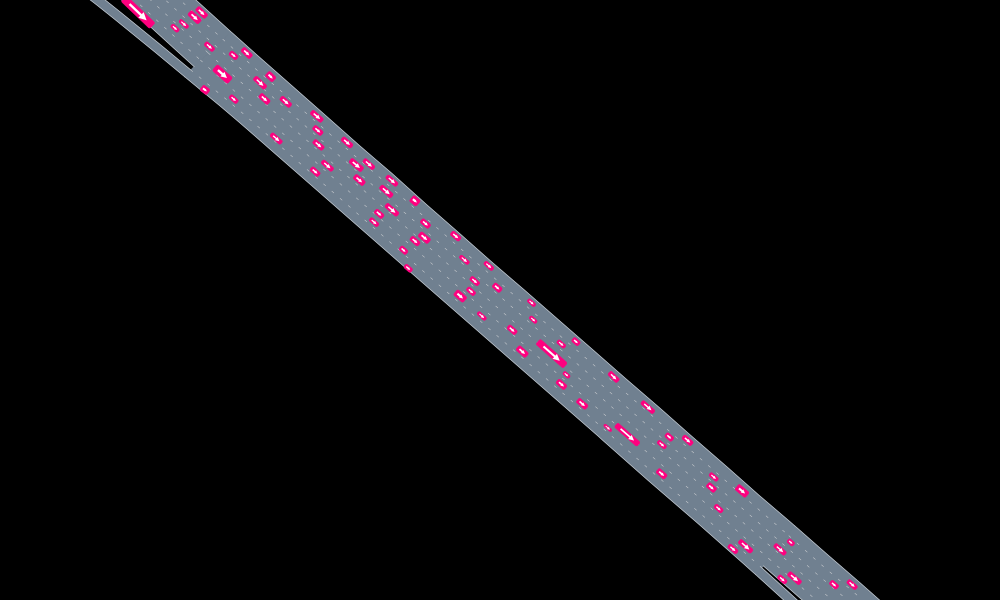

In [5]:
# Sanity check: See if what we have loaded makes sense by rendering a scene
# Test like this is what helped catch the NGSIM occursin order reversing issue
randi = 5
reset(env,random_seed=randi) # Returns an array of features 1x66 
render(env.scene,env.roadway)

In [23]:
env.scene.entities[1].state.posF.t

-0.9008714143259428

In [25]:
env.scene.n

131

In [31]:
env.t

3905

In [ ]:
model = Tim2DDriver(timestep,mlane = MOBIL(timestep));

In [ ]:
# Borrowed from `sisl/gail-driver/validation/validation.jl`
# Reduced T to 0.1 to see more aggressive driving
# Now wondering how to make the blue vehicle change lanes
mlon = IntelligentDriverModel(v_des = 20.0, σ=2.5,k_spd=1.0,T=0.5,s_min=2.0,a_max=3.0,d_cmf=2.5)
mlat = ProportionalLaneTracker(σ=0.1, kp=3.0, kd=2.0)
mlane = MOBIL(timestep,politeness=0.0,advantage_threshold=0.0,safe_decel=3.0)
#mlane = TimLaneChanger(timestep)
model = Tim2DDriver(timestep, mlon=mlon, mlat=mlat, mlane=mlane);

In [ ]:
# TODO: How to define a function with only kwargs and no args?
function run_one_sim(numsteps)
    @show numsteps
    traj = zeros(numsteps,n_veh,66) # 66 observations
    
    data_rmse_t = zeros(numsteps,2)
    data_rmse_vel = zeros(numsteps,2)
    data_rmse_pos = zeros(numsteps,2)
    
    hard_brake_sum = 0
    
    for ii in 1:numsteps
    
        a = zeros(env.n_veh,2)
        
        for (jj,veh) in enumerate(env.ego_vehs)
            observe!(model,env.scene,env.roadway,veh.id)
            latlonacc = rand(model)
            a[jj,1] = latlonacc.a_lat
            a[jj,2] = latlonacc.a_lon
        end
        
        x, r, terminal, info = step(env, a)
        
#         @show info # info contains the rmse information
        
        # Extract rmse information from simulation
        vec_rmse_t = info["rmse_t"]
        vec_rmse_pos = info["rmse_pos"]
        vec_rmse_vel = info["rmse_vel"]
        
        # Compute means over all the agents in this timestep
        mean_rmse_t = mean(vec_rmse_t)
        mean_rmse_vel = mean(vec_rmse_vel)
        mean_rmse_pos = mean(vec_rmse_pos)
        
        # Store rmse into array where column 1 is time and col 2 is the value
        data_rmse_t[ii,1] = ii-1; data_rmse_t[ii,2] = mean_rmse_t
        data_rmse_vel[ii,1] = ii-1; data_rmse_vel[ii,2] = mean_rmse_vel
        data_rmse_pos[ii,1] = ii-1; data_rmse_pos[ii,2] = mean_rmse_pos
        
        
        
        traj[ii,:,:] = x # x is the features: its num_ego_veh x 66
        
#         @show sum(x[:,19]) # 19th column of x captures the is colliding 1 or 0
        @show size(x)
        @show "yo"
        accel_vec = x[:,9]
        
        hard_brake_sum += sum(accel_vec .< -1.0)
        
        dleft_vec = x[:,21]; @show dleft_vec
        dright_vec = x[:,22]; @show dright_vec
        @show min(dleft_vec,dright_vec)
        
        @show find(min(x[:,21],x[:,22])<=-1.0)
    end
    
    # Plotting the rmse stuff
#     figure(0)
#     plot(data_rmse_pos[:,2])
#     figure(1)
#     plot(data_rmse_t[:,2])
#     figure(2)
#     plot(data_rmse_vel[:,2])
    return traj
end

In [ ]:
randi = 15
reset(env,random_seed=randi)
traj = run_one_sim(1);

In [ ]:
data_rmse_pos

In [ ]:
# If you wanted to write data to CSV files
CSV.write("rmse_t.csv",  DataFrame(data_rmse_t), writeheader=false)
CSV.write("rmse_vel.csv",  DataFrame(data_rmse_vel), writeheader=false)
CSV.write("rmse_pos.csv",  DataFrame(data_rmse_pos), writeheader=false)

In [ ]:
using PyPlot

In [ ]:
plot(data_rmse_pos)

## Video making and saving to file

In [ ]:
# Inspired from the drawsim method in AutoViz/doc/AutoViz.ipynb
function makevid(t,dt=NaN)
    
        a = zeros(env.n_veh,2)

        for (jj,veh) in enumerate(env.ego_vehs)
            observe!(model,env.scene,env.roadway,veh.id)

            latlonacc = rand(model)
            a[jj,1] = latlonacc.a_lat
            a[jj,2] = latlonacc.a_lon
        end
        x, r, terminal, _ = step(env, a)
    render(env)
end

In [ ]:
randi = 5
reset(env,random_seed=randi)
film = roll(makevid, fps=10, duration=5.0)
write("numveh_$(env.n_veh)_seed_$(randi)_timlane.gif",film)

## Video making using recorded cars on ngsim
- Trajdatas is what the car trajectories are stored in
- We want to color the ego vehicle differently to be able to see it

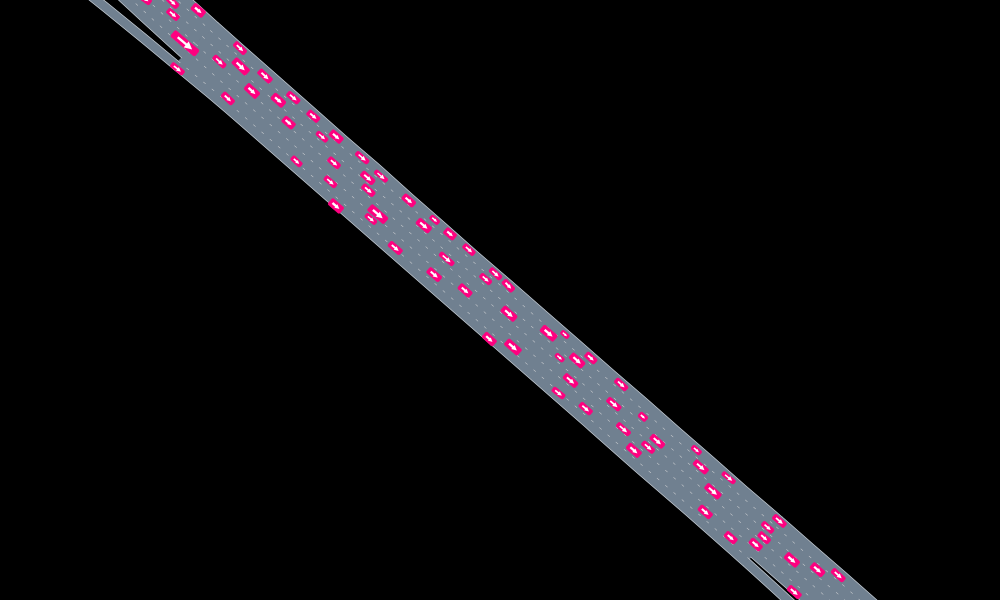

In [32]:
td1 = load_trajdata(1)

scene = Scene(500)
temp_scene = get!(scene,td1,1000)
render(temp_scene,ROADWAY_101)

In [87]:
# argument 1 loads i101 7:50 to 8:05.
# load_trajdata function defined in NGSIM.jl/src/trajdata.jl
td1 = load_trajdata(1); 

scene = Scene(500)
egoid = [25,5,8,9,10,12,21] # These vehicle ids will be colored blue

# List of the vehicle ids in the scene
# veh.id = 2 5 8 9 10 12 13 14 18 20 21 22 23 25 26 27 31 32 34 35 39 48

# Drive here in the notebook. Replay the trajectory as recorded in the ngsim data
@manipulate for i in 100:200
    temp_scene = get!(scene,td1,i)
    
    carcolors = Dict{Int,Colorant}()
    for veh in temp_scene
        #@show veh.id
        # if veh id matches the egoid color it blue otherwise green
        carcolors[veh.id] = 
        in(veh.id, egoid) ? colorant"blue" : colorant"green"
    end
    render(temp_scene, ROADWAY_101, 
        cam=CarFollowCamera{Int}(2,5.0),
#         cam=StaticCamera(VecE2(1966400, 570900), 5.0),
         #cam=FitToContentCamera(0.),
        car_colors=carcolors)
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Scope(Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["i"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")))], Dict{Symbol,Any}(:className=>"interact-flex-row-left")), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>200,:min=>100,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()))], Dict{Symbol,Any}(:className=>"interact-flex-row-center")), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: formatted_val")))], Dict{Symbol,Any}(:className=>"interact-flex-row-right"))], Dict{Symbol,Any}(:className=>"interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"index"=>(Observable{Int64} with 2 listeners. Value:
150, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "/home/raunak/.julia/packages/Knockout/1sDlc/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/home/raunak/.julia/packages/Knockout/1sDlc/src/../assets/knockout_punches.js"), Asset("js", nothing, "/home/raunak/.julia/packages/InteractBase/l8cEC/src/../assets/all.js"), Asset("css", nothing, "/home/raunak/.julia/packages/InteractBase/l8cEC/src/../assets/style.css"), Asset("css", nothing, "/home/raunak/.julia/packages/Interact/0klKX/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes"=>Any[JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index"=>Any[JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), ConnectionPool(Channel{Any}(sz_max:9223372036854775807,sz_curr:0), Set(AbstractConnection[]), Channel{AbstractConnection}(sz_max:32,sz_curr:0)), WebIO.JSString[JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"100\",\"101\",\"102\",\"103\",\"104\",\"105\",\"106\",\"107\",\"108\",\"109\",\"110\",\"111\",\"112\",\"113\",\"114\",\"115\",\"116\",\"117\",\"118\",\"119\",\"120\",\"121\",\"122\",\"123\",\"124\",\"125\",\"126\",\"127\",\"128\",\"129\",\"130\",\"131\",\"132\",\"133\",\"134\",\"135\",\"136\",\"137\",\"138\",\"139\",\"140\",\"141\",\"142\",\"143\",\"144\",\"145\",\"146\",\"147\",\"148\",\"149\",\"150\",\"151\",\"152\",\"153\",\"154\",\"155\",\"156\",\"157\",\"158\",\"159\",\"160\",\"161\",\"162\",\"163\",\"

In [73]:
# Get two subsequent scenes to experiment with
# Note how we had to create a new scene container both times.
    # Wondering why the issue of scene overwriting does not come up in the manipulate
for i in 150:160
    scene = Scene(500)
    t = get!(scene,td1,i)
    display(t.entities[1].state.posF)
    display(t.entities[19].state.posF)
end

Frenet(RoadIndex({89, 0.441723}, {3, 5}), 26.941, -0.003, -0.020)

Frenet(RoadIndex({423, 0.068841}, {4, 1}), 128.678, -0.176, -0.012)

Frenet(RoadIndex({92, 0.881173}, {3, 5}), 27.988, -0.007, -0.017)

Frenet(RoadIndex({427, 0.187653}, {4, 1}), 129.934, -0.194, -0.013)

Frenet(RoadIndex({96, 0.334345}, {3, 5}), 29.040, -0.007, -0.013)

Frenet(RoadIndex({431, 0.302558}, {4, 1}), 131.188, -0.212, -0.014)

Frenet(RoadIndex({99, 0.805337}, {3, 5}), 30.098, -0.004, -0.010)

Frenet(RoadIndex({435, 0.412608}, {4, 1}), 132.441, -0.230, -0.013)

Frenet(RoadIndex({103, 0.297737}, {3, 5}), 31.161, 0.003, -0.007)

Frenet(RoadIndex({439, 0.514962}, {4, 1}), 133.692, -0.249, -0.015)

Frenet(RoadIndex({106, 0.816334}, {3, 5}), 32.233, 0.010, -0.005)

Frenet(RoadIndex({443, 0.612493}, {4, 1}), 134.941, -0.269, -0.013)

Frenet(RoadIndex({110, 0.364119}, {3, 5}), 33.314, 0.019, -0.003)

Frenet(RoadIndex({447, 0.710819}, {4, 1}), 136.191, -0.279, -0.002)

Frenet(RoadIndex({113, 0.943831}, {3, 5}), 34.404, 0.029, -0.001)

Frenet(RoadIndex({451, 0.798292}, {4, 1}), 137.437, -0.277, 0.005)

Frenet(RoadIndex({117, 0.557735}, {3, 5}), 35.505, 0.039, 0.001)

Frenet(RoadIndex({455, 0.874525}, {4, 1}), 138.680, -0.267, 0.010)

Frenet(RoadIndex({121, 0.207263}, {3, 5}), 36.617, 0.050, 0.002)

Frenet(RoadIndex({459, 0.929192}, {4, 1}), 139.916, -0.259, -0.001)

Frenet(RoadIndex({124, 0.893970}, {3, 5}), 37.740, 0.061, 0.004)

Frenet(RoadIndex({463, 0.968563}, {4, 1}), 141.147, -0.271, -0.015)

In [67]:
display(t1.entities[1].state.posF)
display(t2.entities[1].state.posF)

Frenet(RoadIndex({449, 0.703252}, {4, 4}), 136.815, 0.484, -0.010)

Frenet(RoadIndex({454, 0.350555}, {4, 4}), 138.232, 0.463, -0.017)

In [50]:
for i in 1:3
    display(t.entities[i].state.posG)
    display(t.entities[i].state.posF)
end

3-element VecSE2{Float64}:
      1.966381988083237e6
 570918.5351069724       
     -0.7656934897564163 

Frenet(RoadIndex({449, 0.703252}, {4, 4}), 136.815, 0.484, -0.010)

3-element VecSE2{Float64}:
      1.966377536658947e6
 570912.5312361286       
     -0.7619447365467562 

Frenet(RoadIndex({458, 0.431296}, {4, 2}), 139.471, -0.223, -0.006)

3-element VecSE2{Float64}:
      1.9663628786772776e6
 570926.3201644566        
     -0.7640810645853877  

Frenet(RoadIndex({392, 0.429245}, {4, 2}), 119.347, -0.319, -0.005)